In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [4]:
#데이터 불러오기
fashion=pd.read_csv('/Users/jb/Downloads/[0207]_Dimensionality Reduction_실습, 과제/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [9]:
X = fashion.iloc[9001:21001, 1:]
y = fashion.iloc[9001:21001, 0]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

/Users/jb/miniforge3/envs/tf_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jb/miniforge3/envs/tf_m1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


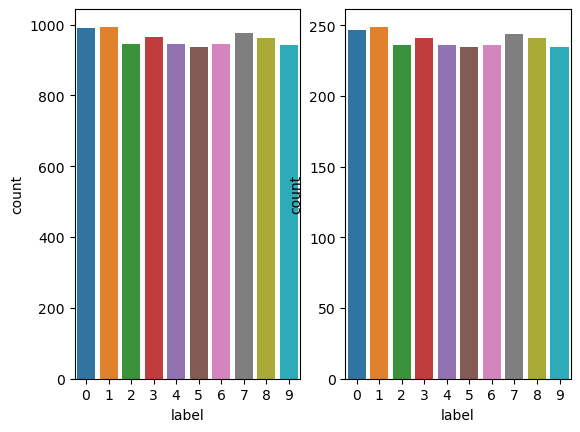

In [11]:
plt.subplot(1, 2, 1)
sns.countplot(y_train)

plt.subplot(1, 2, 2)
sns.countplot(y_test)

plt.show()

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9600, 784) (9600,) (2400, 784) (2400,)


- 어떻게 생긴 데이터셋인지 확인해보기

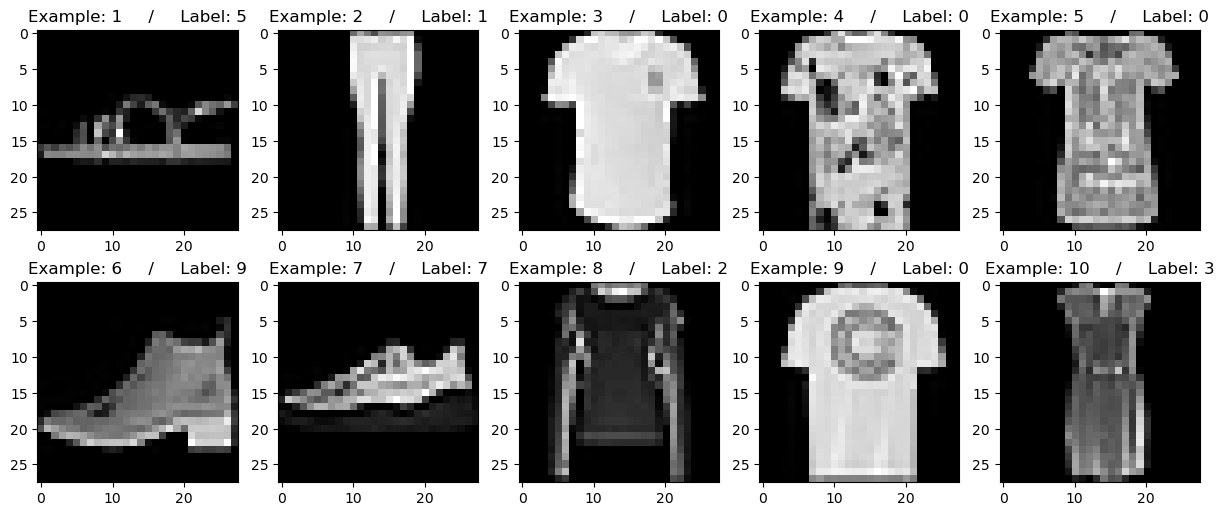

In [64]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.iloc[i]
  image = X_train.iloc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [14]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784)
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(9600, 784)

In [15]:
pca.explained_variance_ratio_[:10]

array([0.28903426, 0.17800118, 0.05960766, 0.04948115, 0.03816426,
       0.03583268, 0.02320705, 0.01951465, 0.01389176, 0.01299126])

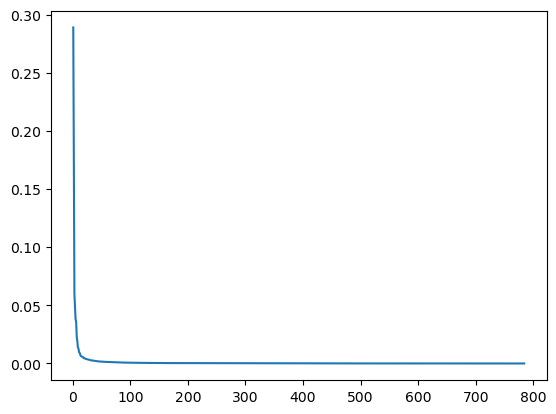

In [16]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

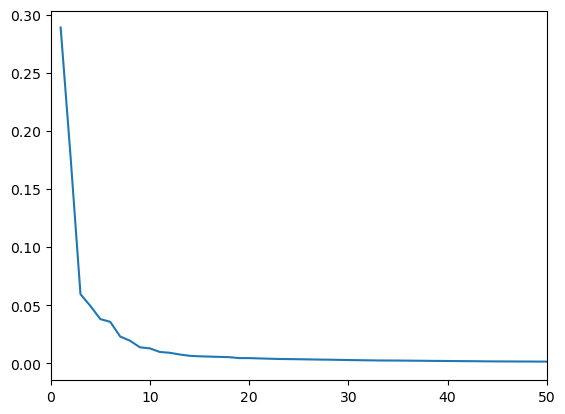

In [20]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

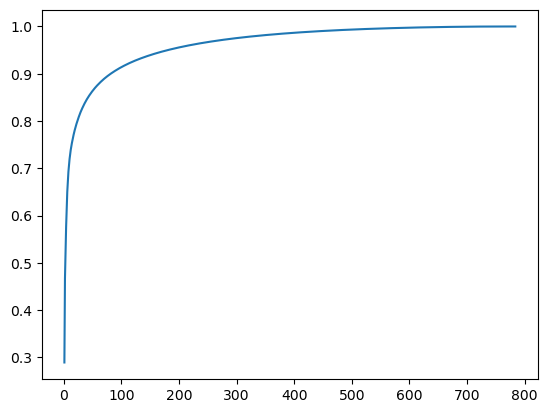

In [21]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

분산을 85% 이상 설명할 수 있는 차원 선택

In [26]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.97%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.56%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 79.78%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 79.78%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 79.78%


In [27]:
cumulative=np.array(cumulative)
np.where(cumulative>0.85)[0][0] #42개 쓰면 분산의 85%이상을 설명

42

In [28]:
pca=PCA(n_components=23)
X_train_PCA=pca.fit_transform(X_train) 
X_test_PCA=pca.transform(X_test)       
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (9600, 784)
After PCA: (9600, 23)


- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


1. Random Forest

In [29]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8604166666666667
6.8044sec


In [30]:
#차원축소 이후(23차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8458333333333333
2.5521sec


* 학습 데이터 수를 늘려봤더니 학습 속도의 감소가 나타남
* PCA 이후 모델의 성능이 1.5% 정도 낮음
* Random Forest에서도 PCA를 고려할 때 학습 속도의 유의미한 개선이 나타날 수 있음

2. LightGBM

In [31]:
from lightgbm import LGBMClassifier 

# 차원축소 이전(784차원)
start=time.time()
lgbm_original=LGBMClassifier()
lgbm_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, lgbm_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, lgbm_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.88375
18.3675sec


In [32]:
# 차원축소 이후(23차원)
start=time.time()
lgbm_pca=LGBMClassifier()
lgbm_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, lgbm_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, lgbm_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.85375
3.4379sec


* 확연한 학습 속도 차이가 나타남
* 3% 정도의 성능 차이는 좀 아쉬움

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

## PCA

In [33]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.1664sec


In [34]:
X_train_PCA

array([[  300.55976828,   851.27827268],
       [-1834.33218582,  -420.60021472],
       [  -46.49638405, -1481.48867062],
       ...,
       [ 1276.57644191,  -160.01395526],
       [ -933.68877342, -1092.60504953],
       [ -919.65780583,  -539.40827577]])

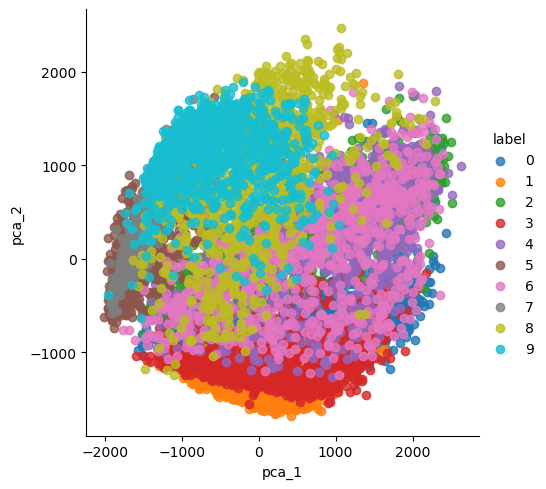

In [35]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca.loc[:, 'label'] = list(y_train)
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

## LDA

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

1.8585sec


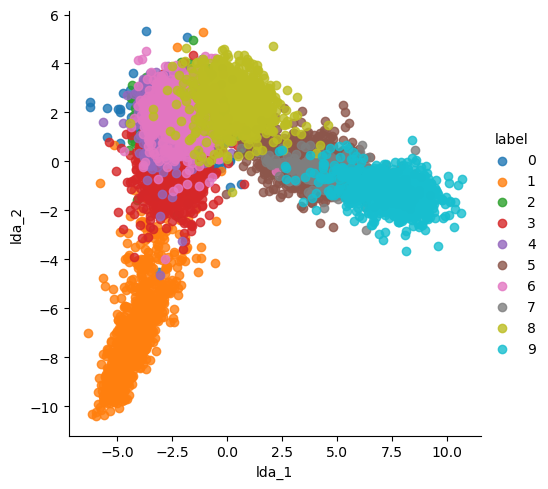

In [37]:
X_train_lda=pd.DataFrame(X_train_lda).iloc[:,0:2]
X_train_lda.loc[:, 'label'] = list(y_train)
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

## t-SNE

In [38]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=20) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/Users/jb/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jb/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


21.3980sec


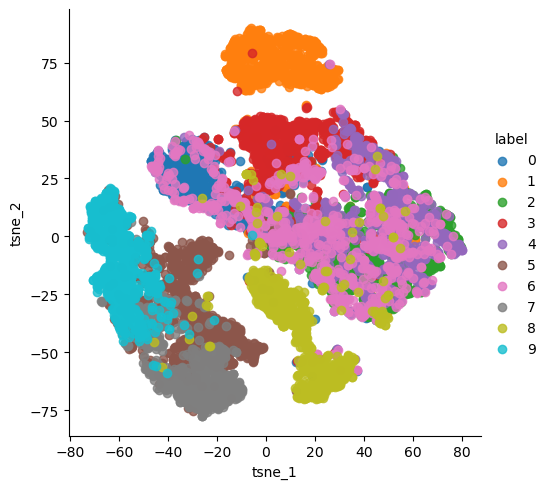

In [39]:
X_train_tsne=pd.DataFrame(X_train_tsne).iloc[:,0:2]
X_train_tsne.loc[:, 'label'] = list(y_train)
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

## ISOMAP

In [40]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=3,n_components=2,n_jobs=10)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

34.8452sec


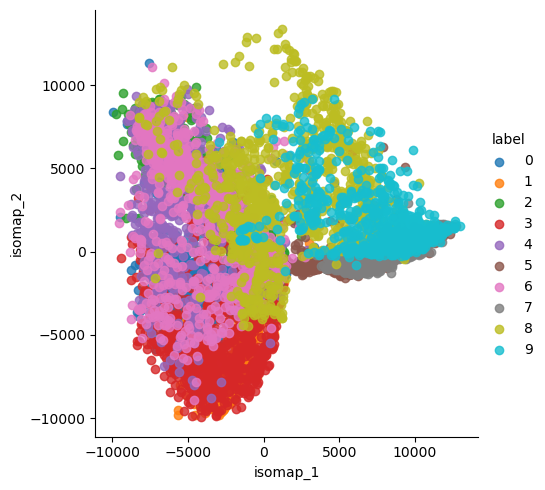

In [41]:
X_train_isomap=pd.DataFrame(X_train_isomap).iloc[:,0:2]
X_train_isomap.loc[:, 'label'] = list(y_train)
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

In [42]:
start=time.time()
isomap=Isomap(n_neighbors=4,n_components=2,n_jobs=10)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

36.8870sec


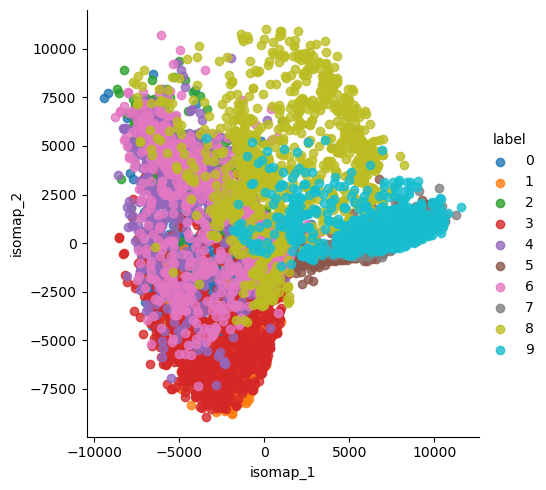

In [43]:
X_train_isomap=pd.DataFrame(X_train_isomap).iloc[:,0:2]
X_train_isomap.loc[:, 'label'] = list(y_train)
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

## KPCA

In [50]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.005, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

10.8283sec


In [51]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.00001, coef0=0.5, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

11.0951sec


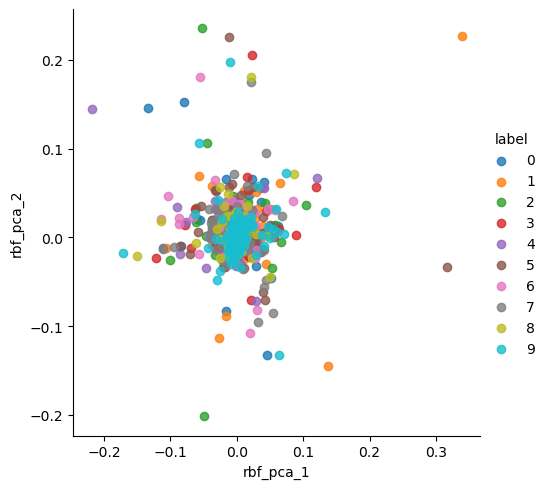

In [52]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).iloc[:,0:2]
X_train_rbf_pca.loc[:, 'label'] = list(y_train)
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

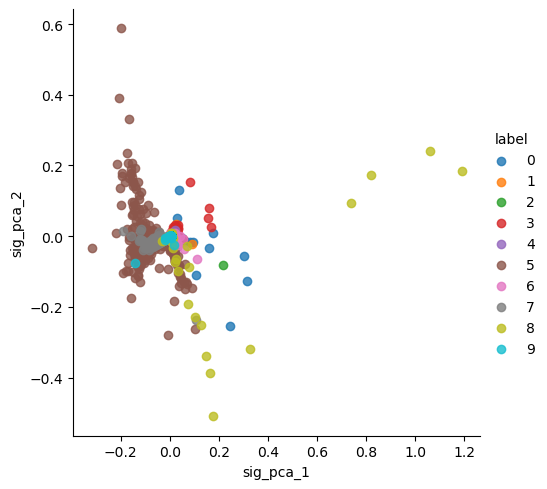

In [53]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).iloc[:,0:2]
X_train_sig_pca.loc[:, 'label'] = list(y_train)
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

## MDS

In [55]:
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

1048.7872sec


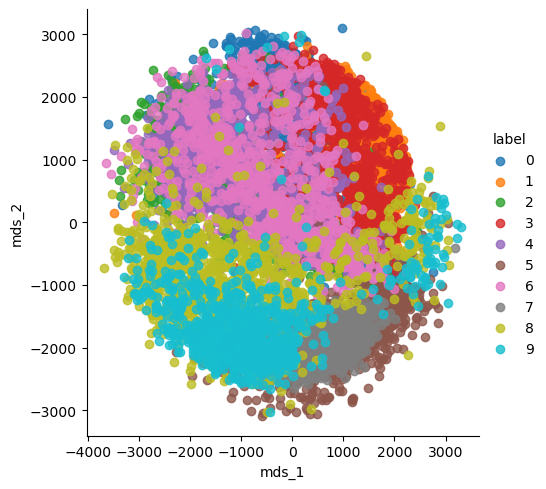

In [56]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds.loc[:, 'label'] = list(y_train)
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

## LLE

In [59]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42, n_neighbors=3)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

1.5916sec


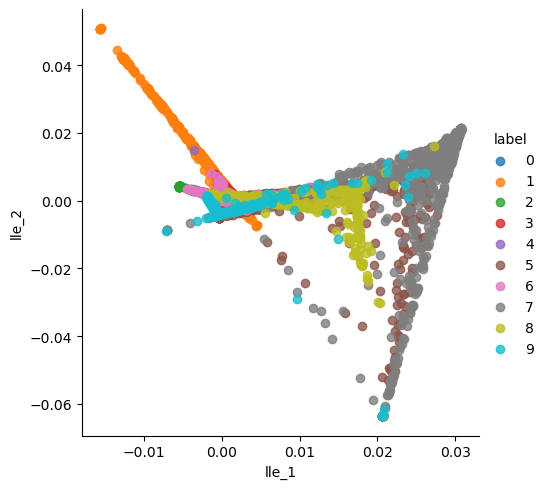

In [60]:
X_train_lle=pd.DataFrame(X_train_lle).iloc[:,0:2]
X_train_lle.loc[:, 'label'] = list(y_train)
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

* t-SNE
* LDA

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

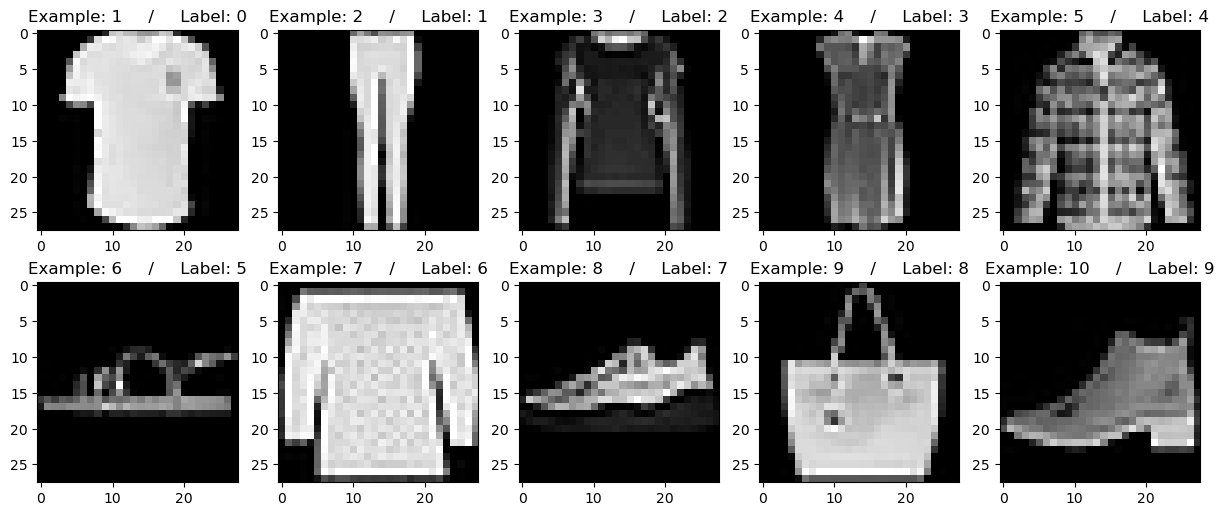

In [91]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train[y_train == i-1].iloc[0]
  idx = y_train[y_train == i-1].index[0]
  image = X_train.loc[idx,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

2번, 4번, 6번은 긴팔 옷들로 서로 겹쳐있는 부분이 많고 5번, 9번은 신발 종류로 이 또한 겹쳐있는 부분이 많다. 언급한 라벨들을 분류하기 위해서는 고차원의 속성을 뽑아내는 것이 필요하다.

수고하셨습니다~